### Libraries

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import math
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image


image_folder = Path.cwd().parent / 'saved_plots'
image_folder.mkdir(exist_ok=True)

### Data

In [118]:
# use 'max_val' to fill in the maximum found value
# plot_axes_input = {
#     "Words Per\n Minute (WPM)": [0, 'max_val'],
#     "Total Error Rate (%)": [0,'max_val'],
#     "Flight Time\n   (ms)": [0,'max_val'],
#     "Hold Time\n  (ms)": [0,'max_val'],
#     "Suggestions": [0,'max_val'],
#     "Autocorrect": [0,'max_val'],
# }

plot_axes_input = {
    "Compliance\n       (%)": [0, 100],
    "Trials per day": [0,'max_val'],
    "Privacy": [0,5],
    "Effort": [0,5],
    "Willingness to Use": ['sporadically','continuously'],
    "Collection": ['scheduled','impromptu'],
}

# the number of columns should match the number of axes
# order is determined by the defined axes

# plot_data = {
#     'PasS': [41.43,10.28, 417, 86, 0.88, 0.81],
#     'ExpT': [48.53,7.02, 358, 84.0, 0.40, 0.33],
#     'ExpC': [36.31, 12.50, 438, 87.8,0.72, 0.51],
#     'ObsT': [53.42, 4.51, 306, 81.4, 0.24, 0.19],
# }

plot_data = {
    'PasS': [0, 79.65,3.88, 1.42, 'continuously', 'impromptu'],
    'ExpT': [89, 0, 4.34, 1.69, 'sporadically','scheduled'],
    'ExpC': [71, 0, 3.96, 2.08, 'sporadically','scheduled'],
}



n_ordinate_levels = 4


 
# find max values, and apply to plot_axes if required
max_values = {}
[max_values.setdefault(title,[]).append(v[i]) for k, v in plot_data.items() for i, title in enumerate(plot_axes_input.keys())]
max_values = {k: max(v) for (k, v) in max_values.items()}    
plot_axes = {k: 
             [max_values[k] if subv == 'max_val' else subv for subv in v]
             for (k, v) in plot_axes_input.items()}


print(f'Data = {plot_data}')
print(f'Axes = {plot_axes}')

Data = {'PasS': [0, 79.65, 3.88, 1.42, 'continuously', 'impromptu'], 'ExpT': [89, 0, 4.34, 1.69, 'sporadically', 'scheduled'], 'ExpC': [71, 0, 3.96, 2.08, 'sporadically', 'scheduled']}
Axes = {'Compliance\n       (%)': [0, 100], 'Trials per day': [0, 79.65], 'Privacy': [0, 5], 'Effort': [0, 5], 'Willingness to Use': ['sporadically', 'continuously'], 'Collection': ['scheduled', 'impromptu']}


In [103]:
# Based on https://datascience.stackexchange.com/questions/6084/how-do-i-create-a-complex-radar-chart

def gen_axes_labels(axes, n_ordinate_levels):

    # check data type by provided ranges for each axis    
    # if a string is in its range or it has other than 2 values, the axes is categorical, else continuous
    result = {}
    for name, ranges in plot_axes.items():
        if any(map(lambda x: not isinstance(x, numbers.Number), ranges)) or len(ranges) != 2:
            result[name] = {
                'type': 'cat',
                'grid': np.linspace(0,1,num=len(ranges)+1),
                'labels': [''] + ranges,
                'minmax': [] 
            }
        else:
            range_labels = np.linspace(*ranges, num=n_ordinate_levels)
            below_ten = any(x < 10.0 for x in range_labels[1:])
            labels= [f'{round(x,1)}' if below_ten else f'{round(x)}' for x in range_labels]
            result[name] = {
                'type': 'cont',
                'grid': np.linspace(0,1,num=n_ordinate_levels),
                'labels': [''] + labels[1:],
                'minmax': ranges
            }
    return result
    
    
def norm_data(unnorm_data, axes_labels):
    
    norm_data = []
    axes_labels_list = list(axes_labels.values())
    
    for index, val in enumerate(unnorm_data):

        this_range = axes_labels_list[index]['labels']
        # if categorical
        if axes_labels_list[index]['type'] == 'cat':

            # must be existing value
            if val not in this_range:
                raise ValueError(f"{val} is not in {this_range}")

            normalised = this_range.index(val)/(len(this_range)-1)
            norm_data.append(normalised)

        # if continuous
        else:
            mini, maxi = axes_labels_list[index]['minmax']
            
            # must be within range
            if (val <= mini and val >= maxi):
                raise ValueError(f"{val} is not between {mini} and {maxi}")

            normalised = (val-mini)/(maxi-mini)
            norm_data.append(normalised)

    return norm_data

def set_rgrids(self, radii, labels=None, angle=None, fmt=None,
               **kwargs):

    # Make sure we take into account unitized data
    radii = self.convert_xunits(radii)
    radii = np.asarray(radii)
    rmin = radii.min()
    # if rmin <= 0:
    #     raise ValueError('radial grids must be strictly positive')
    


    self.set_yticks(radii)
    if labels is not None:
        if angle < 85 or (angle > 175 and angle < 265) or angle > 355:
            self.set_yticklabels([f'  {l}' for l in labels], fontweight='bold', verticalalignment='top')
        else:
            self.set_yticklabels([f'  {l}' for l in labels], fontweight='bold')
    elif fmt is not None:
        self.yaxis.set_major_formatter(FormatStrFormatter(fmt))
    if angle is None:
        angle = self.get_rlabel_position()
    self.set_rlabel_position(angle)
    
    
    for t in self.yaxis.get_ticklabels():
        t.update(kwargs)
    return self.yaxis.get_gridlines(), self.yaxis.get_ticklabels()


class ComplexRadar():
    def __init__(self, fig, axes, n_ordinate_levels = 4, rotation=0):
        
        # create all polar axes
        polar_axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True) for i in range(len(axes))]
        
        # create evenly spaced angles for the number of variables
        angles = np.arange(rotation+0, rotation+360, 360./len(axes))
            
        # create lines (not used) and lables for each axis
        _, text = polar_axes[0].set_thetagrids(angles, labels=axes.keys())
        
        # generate the tick lables for each axes
        self.tick_labels = gen_axes_labels(axes, n_ordinate_levels)
        
        # set grids for each axis
        for i, (k, v) in enumerate(self.tick_labels.items()):
            set_rgrids(polar_axes[i], v['grid'], labels=v['labels'], angle=angles[i])  
    
        # Tweak the looks of the plot here         
        for i, ax in enumerate(polar_axes):
            # keep the x-axis for the first graph
            if i != 0: ax.xaxis.set_visible(False)
            # turn of background and border as they will overlap
            ax.patch.set_visible(False)
            ax.spines["polar"].set_visible(False)
            # avoid autoscaling - we're using normalised data anyway
            ax.set_ylim([0,1.05]) 
            
            ax.grid(color='black', linewidth=.7, linestyle='-')
            ax.grid(False, axis='y')
            ax.tick_params(pad=15)
            
            # format axis labels
            text[i].set_fontweight('semibold')
            text[i].set_fontsize('large')
            text[i].set_fontstyle('italic')
            if angles[i]<50 or angles[i] > 310:
                text[i].set_horizontalalignment('left')
            elif angles[i]>130 and angles[i] < 230:
                text[i].set_horizontalalignment('right')

        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ax = polar_axes[0]
        
        # generate dots to replace gridlines 
        points_per_line = [x['grid'] for x in self.tick_labels.values()]
        max_points = max([len(x) for x in points_per_line])
        points = [np.r_[p, np.full(max_points - len(p), p[len(p)-1])] for p in points_per_line]
        point_scores = []
        for i in range(max_points):
            new_score = [p[i] for p in points]
            point_scores.append(new_score)
        
        for point_list in point_scores[1:]:     
            self.ax.plot(self.angle, np.r_[point_list, point_list[0]], color='black', marker='.', linestyle = 'None')
        
    def plot(self, plot_data, *args, **kw):
        data = norm_data(plot_data,self.tick_labels)
        return self.ax.plot(self.angle, np.r_[data, data[0]], *args, **kw)
        
    def fill(self, plot_data, *args, **kw):
        data = norm_data(plot_data,self.tick_labels)
        return self.ax.fill(self.angle, np.r_[data, data[0]], *args, **kw)
    
def padded(image):
    padding = 15 
    width, height = image.size
    result = Image.new(image.mode, (width + 2*padding, height+2*padding), (255, 0, 0, 0))
    result.paste(image, (padding, padding))
    return result
    

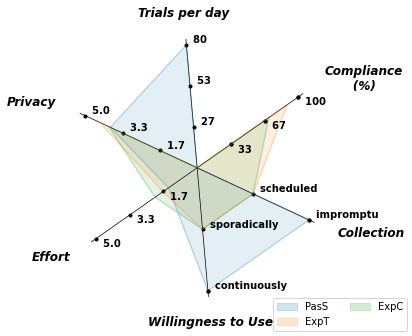

In [119]:

# all in one plot
fig = plt.figure(figsize=(4,4))
radar = ComplexRadar(fig, plot_axes, rotation=35)
matlibcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

legend_handles = []

for i, (k, v) in enumerate(plot_data.items()):
    radar.fill(v, alpha=0.12, color=matlibcolors[i])
    radar.plot(v, alpha=0.2, color=matlibcolors[i])
    legend_handles.append(
        mpatches.Patch(color=matlibcolors[i], alpha=0.2, label=k)
    )

fig.legend(handles=legend_handles, loc='lower right', ncol=2, fontsize='medium')
bbox = fig.get_tightbbox(fig.canvas.get_renderer())
plt.savefig(image_folder / f'complex_radar_combined_tradeoffs.png',bbox_inches=bbox, dpi=72)

plt.show()

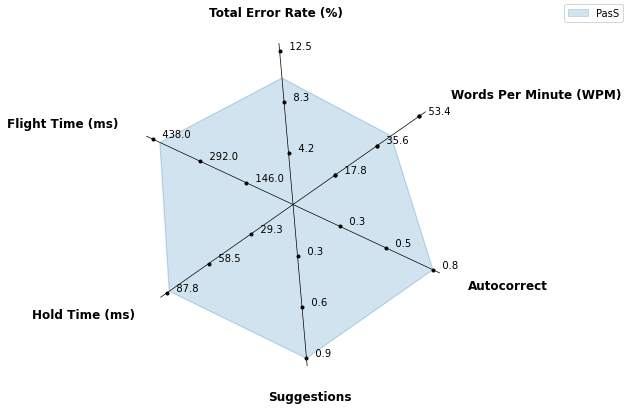

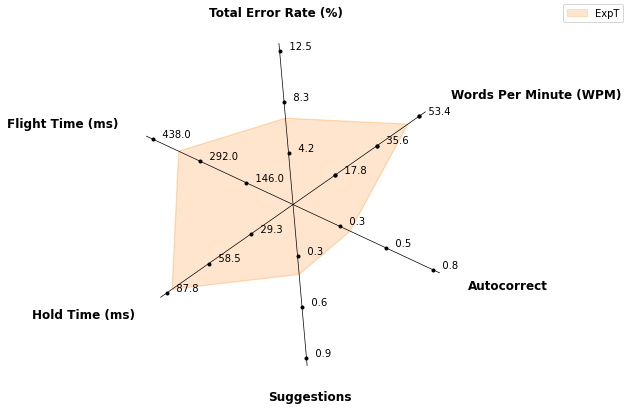

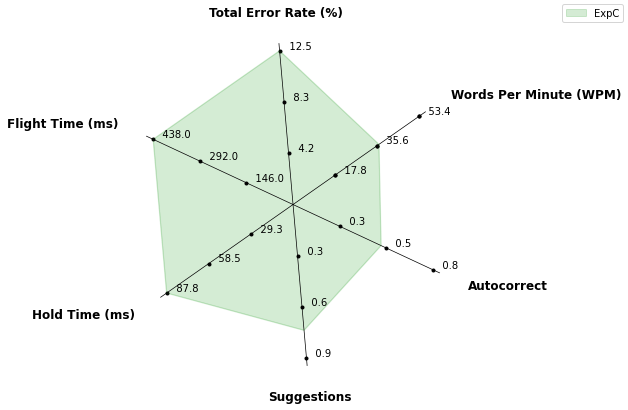

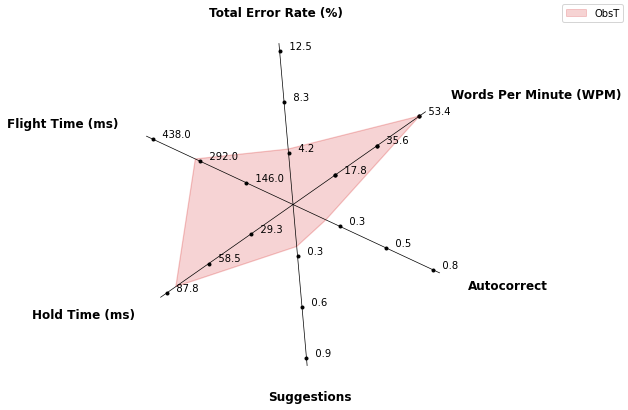

In [71]:
# seperate plots
rotation = 30
matlibcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
figs = []
images = []

for i, (k, v) in enumerate(plot_data.items()):
    figs.append(plt.figure(figsize=(5,5)))
    radar = ComplexRadar(figs[i], plot_axes, rotation=35)
    radar.fill(v, alpha=0.2, color=matlibcolors[i])
    radar.plot(v, alpha=0.1, color=matlibcolors[i])
    figs[i].legend(handles=[mpatches.Patch(color=matlibcolors[i], alpha=0.2, label=k)])
    # get bounding box to include all labels
    bbox = figs[i].get_tightbbox(figs[i].canvas.get_renderer())
    filepath = image_folder / f'complex_radar{i}.png'
    images.append(filepath)
    plt.savefig(filepath,bbox_inches=bbox, dpi=72)
    

concatenated_h = Image.fromarray(
  np.concatenate(
    [np.array(padded(Image.open(x))) for x in images],
    axis=1
  )
)
concatenated_v = Image.fromarray(
  np.concatenate(
    [np.array(padded(Image.open(x))) for x in images],
    axis=0
  )
)
concatenated_h.save(image_folder / 'complex_radar_concat_h.png')
concatenated_v.save(image_folder / 'complex_radar_concat_v.png')
# plt.show()
    